In [1]:
import os
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import segmentation_models_pytorch.utils as smp_utils
import warnings
warnings.filterwarnings("ignore")
from dataset import heartdataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp
import utils
import config
from torchvision import models
# Set seed for reproducibility
utils.seed_everything(config.seed)


/Users/giuliamonopoli/opt/anaconda3/envs/deepvalve/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class_dict = pd.read_csv(config.labels)
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

# print('All dataset classes and their corresponding RGB values in labels:')
# print('Class Names: ', class_names)
# print('Class RGB values: ', class_rgb_values)

# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'leaflet']


ENCODER = config.ENCODER
ENCODER_WEIGHTS = config.ENCODER_WEIGHTS
CLASSES = class_names
ACTIVATION = config.ACTIVATION # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

In [4]:
from torch import nn
import dsntnn

class CoordRegressionNetwork(nn.Module):
    def __init__(self,n_locations):
        super().__init__()
        self.fcn = model
        self.hm_conv = nn.Conv2d(16, n_locations, kernel_size=1, bias=False)

    def forward(self, images):
        # 1. Run the images through our FCN
        fcn_out = self.fcn(images)
        # 2. Use a 1x1 conv to get one unnormalized heatmap per location
        unnormalized_heatmaps = self.hm_conv(fcn_out)
        # 3. Normalize the heatmaps
        heatmaps = dsntnn.flat_softmax(unnormalized_heatmaps)
        # 4. Calculate the coordinates
        coords = dsntnn.dsnt(heatmaps)

        return coords, heatmaps

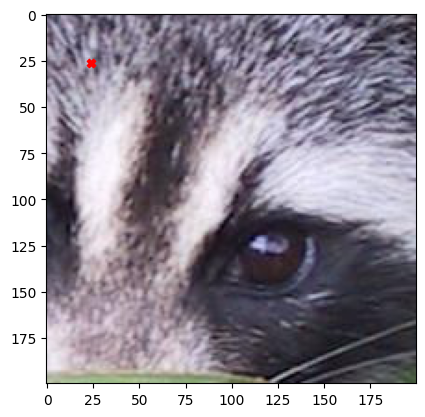

In [8]:
from torch import optim
import matplotlib.pyplot as plt
import scipy.misc
from torchvision.transforms import v2

image_size = [40, 40]
# raccoon_face = scipy.misc.imresize(scipy.misc.face()[200:400, 600:800, :], image_size)
eye_x, eye_y = 24, 26
raccoon_face = v2.Resize(size=image_size)(scipy.misc.face()[200:400, 600:800, :])

plt.imshow(raccoon_face)
plt.scatter([eye_x], [eye_y], color='red', marker='X')
plt.show()

In [10]:
raccoon_face_tensor = torch.from_numpy(raccoon_face).permute(2, 0, 1).float()
input_tensor = raccoon_face_tensor.div(255).unsqueeze(0)
input_var = input_tensor

eye_coords_tensor = torch.Tensor([[[eye_x, eye_y]]])
target_tensor = (eye_coords_tensor * 2 + 1) / torch.Tensor(image_size) - 1
target_var = target_tensor

print('Target: {:0.4f}, {:0.4f}'.format(*list(target_tensor.squeeze())))

Target: 0.2250, 0.3250


In [12]:
model_new = CoordRegressionNetwork(n_locations=1).cuda()

AssertionError: Torch not compiled with CUDA enabled